In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

## 데이터 로드

In [2]:
train_df = pd.read_csv("/content/drive/MyDrive/train.csv")
origin_df = pd.read_csv("/content/drive/MyDrive/Churn_Modelling.csv")

### 데이터 전처리

In [3]:
train_df = pd.concat([train_df.drop(['id','Surname'], axis=1), origin_df.drop(['RowNumber', 'Surname'], axis=1)], ignore_index=True)
train_df.drop_duplicates(inplace = True)
train_df.dropna(inplace=True)

In [4]:
train_df["Gender"]=train_df["Gender"].map({0 :"Male",1 : "Female"})

In [5]:
train_df = train_df.drop(['CustomerId'], axis = 1)
train_df_encoded = pd.get_dummies(train_df, columns=['Geography',
                                       'Gender',
                                       'IsActiveMember',
                                       'HasCrCard',
                                       'NumOfProducts'])
train_df_encoded.head(3)

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,IsActiveMember_0.0,IsActiveMember_1.0,HasCrCard_0.0,HasCrCard_1.0,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,668,33.0,3,0.0,181449.97,0,True,False,False,True,False,False,True,False,True,False,False
1,627,33.0,1,0.0,49503.50,0,True,False,False,False,True,False,True,False,True,False,False
2,678,40.0,10,0.0,184866.69,0,True,False,False,True,False,False,True,False,True,False,False


## 데이터 나누기

In [6]:
X = train_df_encoded.drop('Exited', axis = 1)
y = train_df_encoded['Exited']

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((139866, 16), (34967, 16), (139866,), (34967,))

### 데이터 오버샘플링

In [7]:
smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
X_train_over.shape, y_train_over.shape

((220724, 16), (220724,))

### 모델 성능 출력 함수

In [8]:
def get_clf_eval(y_test, pred, pred_proba):
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred)
    re = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,pred_proba)

    return acc, pre, re, f1, auc

In [9]:
def print_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc = get_clf_eval(y_test, pred, pred_proba)

    print("=> confusion matrix")
    print(confusion)
    print('===========')

    print('Accuracy : {0:.4f}, Precision : {1:.4f}'.format(acc,pre))
    print('Recall : {0:.4f}, F1: {1:.4f}, ROC_AUC: {2:.4f}'.format(re, f1, auc))

### 모델별 결과 정리 함수

In [10]:
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)

    return get_clf_eval(y_test, pred, pred_proba[:,1])

In [11]:
def get_result_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    tmp =[]

    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))

    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [12]:
def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(8,8))

    for model in range(len(models)):
        pred = models[model].predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label= model_names[model])

    plt.plot([0,1],[0,1], 'k--', label='random guess')
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

## Modeling

#### 오버샘플링 전

### 1. Decision Tree GridSearch

In [27]:
params = {'max_depth': [2, 4, 7, 10, 15]}

dt = DecisionTreeClassifier(max_depth=2, random_state=13)

dt_gs = GridSearchCV(estimator=dt, param_grid=params, cv = 5)
dt_gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=2, random_state=13),
             param_grid={'max_depth': [2, 4, 7, 10, 15]})

In [28]:
dt_gs.best_score_, dt_gs.best_params_

(0.8615675027470531, {'max_depth': 7})

In [33]:
dt_gs = dt_gs.best_estimator_
dt_pred = dt_gs.predict(X_test)
dt_proba = dt_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, dt_pred, dt_proba)

=> confusion matrix
[[25982  1562]
 [ 3282  4141]]
Accuracy : 0.8615, Precision : 0.7261
Recall : 0.5579, F1: 0.6310, ROC_AUC: 0.8790


### 2. Logsitic Regression GridSearch

 Logistic Regression 하이퍼 파라미터 종류
- C: 규제 강도를 나타내는 매개변수입니다. 값이 작을수록 규제가 강해지고, 모델이 단순해집니다. 기본값은 1.0입니다.
- penalty: 규제 유형을 지정하는 매개변수입니다. 'l1' 또는 'l2'를 선택할 수 있으며, 기본값은 'l2'입니다. 'l1'은 L1 규제를 나타내며, 'l2'는 L2 규제를 나타냅니다.
   - l1 : 라쏘회귀, 모델의 설명력에 기여하지 못하는 독립변수의 회귀계수를 0으로 만든다. 특성이 제외됨(모델의 단순화)
   - l2 : 릿지회귀, 모델의 설명력에 기여하지 못하는 독립변수의 회귀계수를 가능한 작게 만들어 특성이 출력에 주는 영향을 최소화
- solver: 비용함수의 최솟값을 어떠한 방법으로 찾을 것인지를 지정하는 역할로 최적화에 사용할 알고리즘을 지정하는 매개변수이다.
 다양한 최적화 알고리즘이 있으며, 예를 들어, 'saga', 'liblinear', 'newton-cg' 등이 있습니다.
     - newton-cg : 경사하강법과 마찬가지로 여러 번의 업데이트를 통해서 비용함수를 최소화하는 파라미터의 값을 찾는 방법이다. 하지만 2차 도함수를 계산하는 것이 필요하다는 단점
     - liblinear : 경사하강법은 한 번에 여러개의 파라미터를 업데이트하지만, liblinear은 한 번에 하나의 파라미터만 업데이트한다는 점이 다르다.
     - saga :  경사하강법과 유사하게 작동하지만, 차이점은 이전 업데이트 단계에서의 경사값을 현재 업데이트에 사용한다는 점이다. 이렇게 하면 학습속도가 더 빨라지는 장점이 있다.
- max_iter: 최적화 알고리즘의 최대 반복 횟수를 나타내는 매개변수입니다. 기본값은 100입니다.

In [36]:
params = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['saga', 'liblinear', 'newton-cg'],
              'max_iter': [100, 300, 500]}

lr = LogisticRegression(random_state=13)
lr_gs = GridSearchCV(estimator=lr, param_grid=params, cv = 5, n_jobs = -1)
lr_gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=13), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 300, 500], 'penalty': ['l1', 'l2'],
                         'solver': ['saga', 'liblinear', 'newton-cg']})

In [37]:
lr_gs.best_score_, lr_gs.best_params_

(0.8518582145228129,
 {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'})

In [38]:
lr_gs = lr_gs.best_estimator_
lr_pred = lr_gs.predict(X_test)
lr_proba = lr_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, lr_pred, lr_proba)

=> confusion matrix
[[26125  1419]
 [ 3766  3657]]
Accuracy : 0.8517, Precision : 0.7204
Recall : 0.4927, F1: 0.5852, ROC_AUC: 0.8648


### 3. Random Forest GridSearch

In [39]:
params = {
	'n_estimators':[50, 100, 200],
	'max_depth':[6, 8, 10, 12],
	'min_samples_leaf':[8, 12, 18],
	'min_samples_split':[8, 12, 18]
}

rf = RandomForestClassifier(random_state = 13, n_jobs = -1)
rf_gs = GridSearchCV(estimator = rf, cv = 5, param_grid = params, n_jobs = -1)
rf_gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [8, 12, 18],
                         'min_samples_split': [8, 12, 18],
                         'n_estimators': [50, 100, 200]})

In [40]:
rf_gs.best_score_, rf_gs.best_params_

(0.8621323315856841,
 {'max_depth': 12,
  'min_samples_leaf': 8,
  'min_samples_split': 8,
  'n_estimators': 100})

In [41]:
rf_gs = rf_gs.best_estimator_
rf_pred = rf_gs.predict(X_test)
rf_proba = rf_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, rf_pred, rf_proba)

=> confusion matrix
[[26239  1305]
 [ 3492  3931]]
Accuracy : 0.8628, Precision : 0.7508
Recall : 0.5296, F1: 0.6211, ROC_AUC: 0.8830


### 4. LightGBM GridSearch

In [ ]:
from lightgbm import early_stopping
params = {
    'boosting_type': ['gbdt'],
    'n_estimators': [100, 300, 1000],
    'max_depth' : [8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'subsample': [0.8, 0.9, 1.0],
}

lgbm = LGBMClassifier(random_state = 13, n_jobs = -1, n_estimators = 100)

lgbm_gs = GridSearchCV(estimator = lgbm, param_grid = params, cv = 5)
early_stopping_rounds = 10
eval_set =  [(X_test, y_test)]
lgbm_gs = lgbm_gs.fit(X_train, y_train, eval_set = [(X_test, y_test)], callbacks=[early_stopping(10, verbose=2)])

In [43]:
lgbm_gs.best_score_, lgbm_gs.best_params_

(0.8631261406609567,
 {'aplication': 'binary',
  'boosting_type': 'gbdt',
  'learning_rate': 0.01,
  'max_depth': 8,
  'n_estimators': 1000,
  'num_leaves': 31,
  'subsample': 0.8})

In [44]:
lgbm_gs = lgbm_gs.best_estimator_
lgbm_pred = lgbm_gs.predict(X_test)
lgbm_pred_proba = lgbm_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, lgbm_pred, lgbm_pred_proba)

[LightGBM] [Warning] Unknown parameter: aplication
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: aplication
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
=> confusion matrix
[[26123  1421]
 [ 3357  4066]]
Accuracy : 0.8634, Precision : 0.7410
Recall : 0.5478, F1: 0.6299, ROC_AUC: 0.8850


### 5. XGBoost GridSearch

In [52]:
params = {
    'n_estimators': [100, 300, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8],
}

xgb = XGBClassifier(random_state = 13, n_jobs = -1)

xgb_gs = GridSearchCV(estimator = xgb, param_grid = params, cv = 3, verbose = 2, n_jobs = -1)
xgb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=13, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 300, 1000], 'subsample': [0.8]},
             verbose=2)

In [53]:
xgb_gs.best_score_, xgb_gs.best_params_

(0.8629688416055368,
 {'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.8})

In [56]:
xgb_gs = xgb_gs.best_estimator_
xgb_pred = xgb_gs.predict(X_test)
xgb_pred_proba = xgb_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, xgb_pred, xgb_pred_proba)

=> confusion matrix
[[26089  1455]
 [ 3362  4061]]
Accuracy : 0.8622, Precision : 0.7362
Recall : 0.5471, F1: 0.6277, ROC_AUC: 0.8851


### 모델별 성능 정리

1. Accuracy (정확도) : 전체 예측 중에서 올바르게 분류된 비율을 나타내는 지표
   - 전체 고객의 이탈 여부를 얼마나 잘 예측했는가?
2. Recall (재현율) : 실제 양성인 샘플 중에서 모델이 올바르게 양성으로 분류한 비율
   - 실제 이탈 고객 중 얼마나 이탈로 잘 예측했는가? -> 모든 이탈 고객을 다 찾아야하는 상황에 중점(미검출)
3. Precision (정밀도) : 모델이 양성으로 분류한 샘플 중에서 실제 양성인 비율
   - 이탈로 예측한 고객들 중 실제 이탈 고객의 비율 -> 정확한 고객 이탈 예측 상황에 중점(오검출)
4. F1 Score (F1 스코어) : 정밀도와 재현율의 조화 평균으로 계산된 지표로, 높은 정밀도와 재현율을 모두 고려하기 때문에 양성 및 음성 예측의 균형을 평가
5. ROC-AUC : 모델이 얼마나 잘 양성 및 음성 클래스를 구별하는지를 측정하는데 사용, 모델의 성능을 종합적으로 평가

In [57]:
tmp = []
col_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost']

tmp.append(get_clf_eval(y_test, dt_pred, dt_proba))
tmp.append(get_clf_eval(y_test, lr_pred, lr_proba))
tmp.append(get_clf_eval(y_test, rf_pred, rf_proba))
tmp.append(get_clf_eval(y_test, lgbm_pred, lgbm_pred_proba))
tmp.append(get_clf_eval(y_test, xgb_pred, xgb_pred_proba))

result = pd.DataFrame(tmp, columns=col_names, index=model_names)
result

,Accuracy,Precision,Recall,F1,ROC_AUC
LogisticReg,0.861469,0.726109,0.557861,0.630961,0.878989
DecisionTree,0.851717,0.720449,0.492658,0.585167,0.864818
RandomForest,0.862814,0.750764,0.529570,0.621060,0.883004
LightGBM,0.863357,0.741024,0.547757,0.629899,0.884958
XGBoost,0.862242,0.736222,0.547083,0.627715,0.885096


- GridSearch를 통해 최적의 모델을 찾다보니 대체적으로 성능 지표가 좋게 나왔다.
- DecisionTree의 Recall 지표가 다른 모델에 비해서 조금 떨어진다.
- LightGBM과 XGBoost의 모델의 성능이 가장 좋은 것으로 나온다.

In [58]:
models = [lr_gs, dt_gs, rf_gs, lgbm_gs, xgb_gs]
# model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost']

# results = get_result_pd(models, model_names, X_train, y_train, X_test, y_test)
# results

[LightGBM] [Warning] Unknown parameter: aplication
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


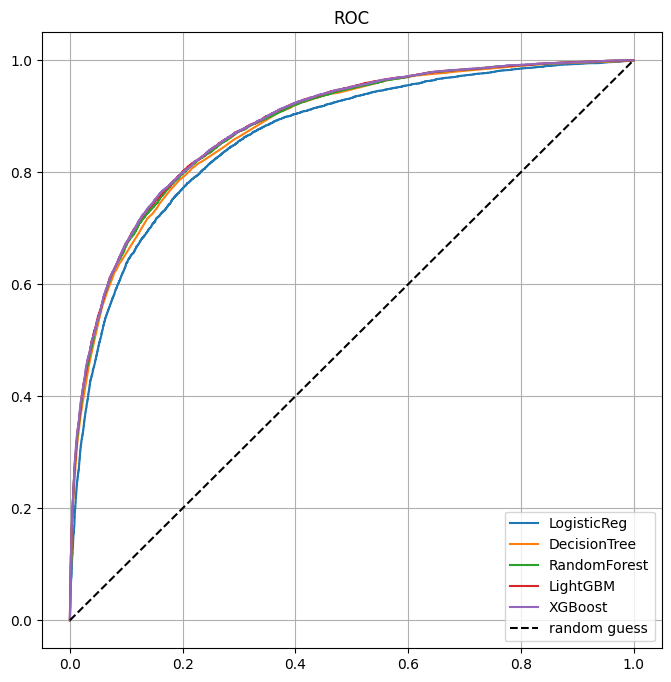

In [59]:
draw_roc_curve(models, model_names, X_test, y_test)

#### 오버샘플링 후

### Decision Tree

In [23]:
params = {'max_depth': [2, 4, 7, 10, 15]}

dt = DecisionTreeClassifier(max_depth=2, random_state=13)

dt_gs = GridSearchCV(estimator=dt, param_grid=params, cv = 3)
dt_gs.fit(X_train_over, y_train_over)
dt_gs.best_score_, dt_gs.best_params_

(0.8623441453250896, {'max_depth': 7})

In [24]:
dt_sampling_gs = dt_gs.best_estimator_
dt_pred = dt_sampling_gs.predict(X_test)
dt_proba = dt_sampling_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, dt_pred, dt_proba)

=> confusion matrix
[[23742  3802]
 [ 2183  5240]]
Accuracy : 0.8288, Precision : 0.5795
Recall : 0.7059, F1: 0.6365, ROC_AUC: 0.8730


### Logistic Regression

In [25]:
params = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'solver': ['saga', 'liblinear', 'newton-cg'],
              'max_iter': [100, 300, 500]}

lr = LogisticRegression(random_state=13)

lr_gs = GridSearchCV(estimator=lr, param_grid=params, cv = 3, n_jobs = -1)
lr_gs.fit(X_train_over,y_train_over)
lr_gs.best_score_, lr_gs.best_params_

(0.8629332260007802,
 {'C': 100, 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg'})

In [26]:
lr_sampling_gs = lr_gs.best_estimator_
lr_pred = lr_sampling_gs.predict(X_test)
lr_proba = lr_sampling_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, lr_pred, lr_proba)

=> confusion matrix
[[25370  2174]
 [ 3069  4354]]
Accuracy : 0.8501, Precision : 0.6670
Recall : 0.5866, F1: 0.6242, ROC_AUC: 0.8639


### Random Forest

In [14]:
params = {
	'n_estimators':[50, 100, 200],
	'max_depth':[6, 8, 10, 12],
	'min_samples_leaf':[8, 12, 18],
	'min_samples_split':[8, 12, 18]
}
rf = RandomForestClassifier(random_state = 13, n_jobs = -1)

rf_gs = GridSearchCV(estimator = rf, param_grid = params, cv = 3, n_jobs = -1)
rf_gs.fit(X_train_over, y_train_over)
rf_gs.best_score_, rf_gs.best_params_

(0.8736841756927317,
 {'max_depth': 12,
  'min_samples_leaf': 12,
  'min_samples_split': 8,
  'n_estimators': 50})

In [15]:
rf_sampling_gs = rf_gs.best_estimator_
rf_pred = rf_sampling_gs.predict(X_test)
rf_proba = rf_sampling_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, rf_pred, rf_proba)

=> confusion matrix
[[25222  2322]
 [ 2715  4708]]
Accuracy : 0.8559, Precision : 0.6697
Recall : 0.6342, F1: 0.6515, ROC_AUC: 0.8817


### LightGBM

In [19]:
params = {
    'boosting_type': ['gbdt'],
    'n_estimators': [100, 300, 1000],
    'max_depth' : [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63, 127],
    'subsample': [0.8],
}
from lightgbm import early_stopping
lgbm = LGBMClassifier(random_state = 13, n_jobs = -1, n_estimators = 100)
lgbm_gs = GridSearchCV(estimator = lgbm, param_grid = params, cv = 3, verbose=0)
lgbm_gs = lgbm_gs.fit(X_train_over, y_train_over, eval_set = [(X_test, y_test)], callbacks=[early_stopping(10, verbose=0)])
lgbm_gs.best_score_, lgbm_gs.best_params_

[LightGBM] [Info] Number of positive: 73575, number of negative: 73574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 147149, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500003 -> initscore=0.000014
[LightGBM] [Info] Start training from score 0.000014
[LightGBM] [Info] Number of positive: 73574, number of negative: 73575
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 147149, number of used features: 16
[LightGBM] [Info] 

(0.8879417859449265,
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 1000,
  'num_leaves': 31,
  'subsample': 0.8})

(0.8879417859449265,
 {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 1000,
  'num_leaves': 31,
  'subsample': 0.8})

In [20]:
lgbm_sampling_gs = lgbm_gs.best_estimator_
lgbm_pred = lgbm_sampling_gs.predict(X_test)
lgbm_pred_proba = lgbm_sampling_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, lgbm_pred, lgbm_pred_proba)

=> confusion matrix
[[25846  1698]
 [ 3141  4282]]
Accuracy : 0.8616, Precision : 0.7161
Recall : 0.5769, F1: 0.6390, ROC_AUC: 0.8844


### XGBoost

In [ ]:
params = {
    'n_estimators': [100, 300, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8],
}
xgb = XGBClassifier(random_state = 13, n_jobs = -1)

xgb_gs = GridSearchCV(estimator = xgb, param_grid = params, cv = 3, verbose = 2, n_jobs = -1)
xgb_gs.fit(X_train_over, y_train_over)
xgb_gs.best_score_, xgb_gs.best_params_

In [22]:
xgb_sampling_gs = xgb_gs.best_estimator_
xgb_pred = xgb_sampling_gs.predict(X_test)
xgb_pred_proba = xgb_sampling_gs.predict_proba(X_test)[:,1]

print_clf_eval(y_test, xgb_pred, xgb_pred_proba)

=> confusion matrix
[[25183  2361]
 [ 2708  4715]]
Accuracy : 0.8550, Precision : 0.6663
Recall : 0.6352, F1: 0.6504, ROC_AUC: 0.8816


In [28]:
tmp = []
col_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']
model_names = ['LogisticReg', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost']

tmp.append(get_clf_eval(y_test, dt_pred, dt_proba))
tmp.append(get_clf_eval(y_test, lr_pred, lr_proba))
tmp.append(get_clf_eval(y_test, rf_pred, rf_proba))
tmp.append(get_clf_eval(y_test, lgbm_pred, lgbm_pred_proba))
tmp.append(get_clf_eval(y_test, xgb_pred, xgb_pred_proba))

result = pd.DataFrame(tmp, columns=col_names, index=model_names)
result

,Accuracy,Precision,Recall,F1,ROC_AUC
LogisticReg,0.828839,0.579518,0.705914,0.636502,0.872996
DecisionTree,0.850059,0.666973,0.586555,0.624185,0.863935
RandomForest,0.855950,0.669701,0.634245,0.651491,0.881726
LightGBM,0.861612,0.716054,0.576856,0.638961,0.884423
XGBoost,0.855035,0.666337,0.635188,0.650390,0.881627


- 오버 샘플링 후의 모델과 전의 모델을 같이 비교해보았을 때 전체적인 성능 부분에서는 큰 차이는 보이지 않는다.
- 주로 볼만한 부분은 Precision과 Recall 부분에서 Trade_off 관계를 보이는 것이다.
- 오버 샘플링 전은 비교적 Precision이 높았고 Recall이 낮았다면 오버 샘플링 후에는 Precision이 낮아졌고 Recall이 높아졌다.
>>> 

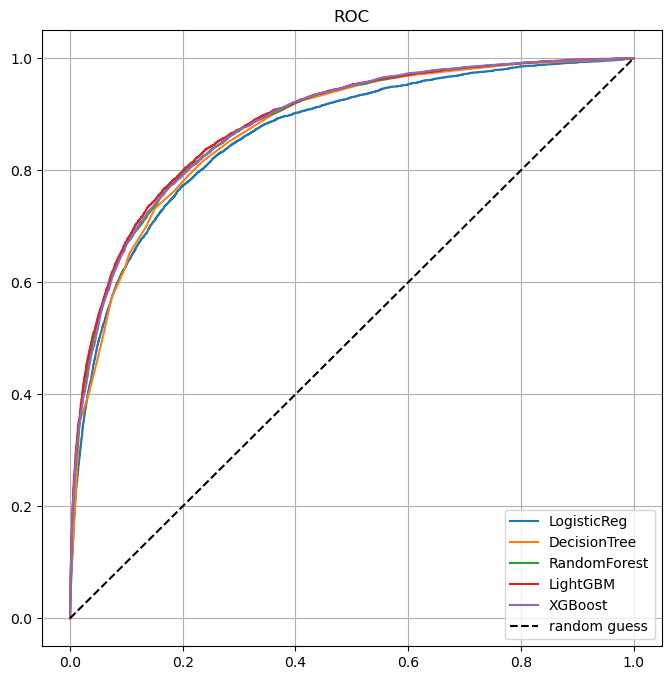

In [30]:
models = [lr_gs, dt_gs, rf_gs, lgbm_gs, xgb_gs]

draw_roc_curve(models, model_names, X_test, y_test)